In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
cost_h, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(cost_h)
# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)
print(driver_h)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

def falqon( n, beta_1, delta_t, dev):
    comm_h = build_commutator_hamiltonian(driver_h, cost_h)

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha")
    return beta, energies

n = 4000
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=qubits) # Creates a device for the simulation
res_beta, res_energies = falqon(n, beta_1, delta_t, dev)
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

Qubits: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
1.0 * X(0) + 1.0 * X(1) + 1.0 * X(2) + 1.0 * X(3)
第 1 步: E = 0.77775067 Ha
第 2 步: E = 0.77565396 Ha
第 3 步: E = 0.77145745 Ha
第 4 步: E = 0.76450462 Ha
第 5 步: E = 0.75419454 Ha
第 6 步: E = 0.74001577 Ha
第 7 步: E = 0.72158888 Ha
第 8 步: E = 0.69871333 Ha
第 9 步: E = 0.67141103 Ha
第 10 步: E = 0.63995608 Ha
第 11 步: E = 0.60487908 Ha
第 12 步: E = 0.56693798 Ha
第 13 步: E = 0.52705405 Ha
第 14 步: E = 0.48622170 

KeyboardInterrupt: 

-0.09706626816763125 * I(0) + 0.17141282644776926 * Z(0) + 0.1714128264477692 * Z(1) + -0.22343153690813433 * Z(2) + -0.22343153690813433 * Z(3) + 0.16868898170361205 * (Z(0) @ Z(1)) + 0.12062523483390411 * (Z(0) @ Z(2)) + 0.16592785033770338 * (Z(0) @ Z(3)) + 0.16592785033770338 * (Z(1) @ Z(2)) + 0.12062523483390411 * (Z(1) @ Z(3)) + 0.17441287612261575 * (Z(2) @ Z(3)) + -0.04530261550379926 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04530261550379926 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.04530261550379926 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04530261550379926 * (Y(0) @ Y(1) @ X(2) @ X(3))
1.0 * X(0) + 1.0 * X(1) + 1.0 * X(2) + 1.0 * X(3)
第 1 步: E = -0.09720070 Ha
第 2 步: E = -0.09773020 Ha
第 3 步: E = -0.09881166 Ha
第 4 步: E = -0.10062325 Ha
第 5 步: E = -0.10333603 Ha
第 6 步: E = -0.10710984 Ha
第 7 步: E = -0.11208792 Ha
第 8 步: E = -0.11839043 Ha
第 9 步: E = -0.12610712 Ha
第 10 步: E = -0.13528967 Ha
第 11 步: E = -0.14594461 Ha
第 12 步: E = -0.15802777 Ha
第 13 步: E = -0.17144146 Ha
第 14 步: E = -0.18603530 H

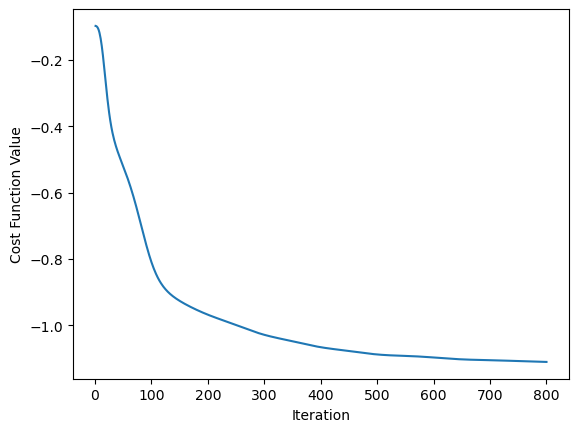

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
from pennylane.qchem import molecular_hamiltonian

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
import scipy

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: 构造 OpenFermion 分子对象（不要用 PySCF 的 gto.Mole）
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]  # 单位为 Å
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

# Step 2: 运行 PySCF 计算（RHF + 哈密顿量）
molecule = run_pyscf(molecule, run_scf=True)

# Step 3: Jordan-Wigner 变换为 Qubit Hamiltonian
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Step 4: 转换为稀疏矩阵（如需矩阵形式演化）
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))  # 只保留实部
    return Hamiltonian(coeffs, ops)

# 调用转换函数
n_qubits = molecule.n_qubits
cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

print(cost_h)
# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)
print(driver_h)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

def falqon( n, beta_1, delta_t, dev):
    comm_h = build_commutator_hamiltonian(driver_h, cost_h)

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha")
    return beta, energies

n = 800
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=qubits) # Creates a device for the simulation
res_beta, res_energies = falqon(n, beta_1, delta_t, dev)
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
cost_h, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(cost_h)

/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.3 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Qubits: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
